In [139]:
import cv2
import numpy as np

#image = cv2.imread('crop_D0_0db9c565-60a5-11ec-8402-0a7404972c70.png', cv2.IMREAD_GRAYSCALE)
image = cv2.imread('crop_D0_0d4f0dab-60a5-11ec-8402-0a7404972c70.png', cv2.IMREAD_GRAYSCALE)

# 이진화
_, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY)

# 컨투어 찾기
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 눈알 영역만 추출
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    eye = image[y:y+h, x:x+w]

# 사이즈 224x224로 변경
resize_eye = cv2.resize(eye, dsize=(224, 224), interpolation=cv2.INTER_AREA)
# 결과 출력
cv2.imshow('Eye', resize_eye)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imwrite('eye.png', resize_eye)

True

In [140]:
import tensorflow as tf
# 정규화
normalize_image = resize_eye / 255.0
mean = tf.reduce_mean(normalize_image)
stddev = tf.math.reduce_std(normalize_image)

standardization_image = (normalize_image - mean) / stddev

#standardized_image_uint8 = cv2.convertScaleAbs(standardization_image.numpy() * 255.0)
#cv2.imwrite('standardized_image.png', standardized_image_uint8)

(-0.5, 223.5, 223.5, -0.5)

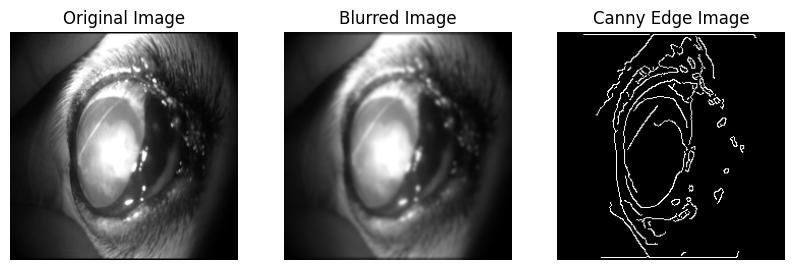

In [141]:
import matplotlib.pyplot as plt

image = cv2.imread('eye.png', cv2.IMREAD_GRAYSCALE)
#image = np.array(standardization_image)
blurred = cv2.GaussianBlur(image, (5, 5), 1.4)
canny_edge = cv2.Canny(blurred, 50, 150)

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(blurred, cmap='gray')
ax[1].set_title('Blurred Image')
ax[1].axis('off')

ax[2].imshow(canny_edge, cmap='gray')
ax[2].set_title('Canny Edge Image')
ax[2].axis('off')

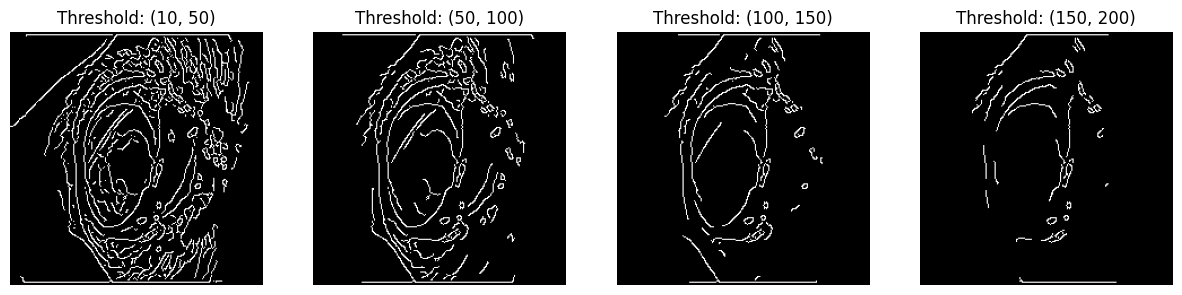

In [142]:
threshold = [(10, 50), (50, 100), (100, 150), (150, 200)]

canny_result = []

for th1, th2 in threshold:
    canny_edge = cv2.Canny(blurred, th1, th2)
    canny_result.append(canny_edge)
    
fig, ax = plt.subplots(1, 4, figsize=(15, 5))

for i in range(4):
    ax[i].imshow(canny_result[i], cmap='gray')
    ax[i].set_title(f'Threshold: {threshold[i]}')
    ax[i].axis('off')

In [143]:
import numpy as np

def generate_salt_noise(image):
    num_salt = np.ceil(0.05 * np.prod(image.shape))  # 이미지의 전체 픽셀 개수를 계산
    coords = [np.random.randint(0, dim, int(num_salt)) for dim in image.shape]  # 이미지의 각 차원에 대해 좌표 생성
    indices = tf.convert_to_tensor(np.transpose(coords))  # 좌표를 Tensor로 변환
    updates = tf.constant(255, shape=(int(num_salt),), dtype=image.dtype)  # 업데이트할 값
    salted_image = tf.tensor_scatter_nd_update(image, indices, updates)  # 픽셀 좌표에 소금 잡음 추가
    return salted_image

def generate_pepper_noise(image):
    num_pepper = np.ceil(0.05 * np.prod(image.shape))  # 이미지의 전체 픽셀 개수를 계산
    coords = [np.random.randint(0, dim, int(num_pepper)) for dim in image.shape]  # 이미지의 각 차원에 대해 좌표 생성
    indices = tf.convert_to_tensor(np.transpose(coords))  # 좌표를 Tensor로 변환
    updates = tf.constant(0, shape=(int(num_pepper),), dtype=image.dtype)  # 업데이트할 값
    peppered_image = tf.tensor_scatter_nd_update(image, indices, updates)  # 픽셀 좌표에 후추 잡음 추가
    return peppered_image
salted_image = generate_salt_noise(image)
peppered_image = generate_pepper_noise(salted_image)

peppered_image_np = peppered_image.numpy()
filtered_image = cv2.medianBlur(image, 5)

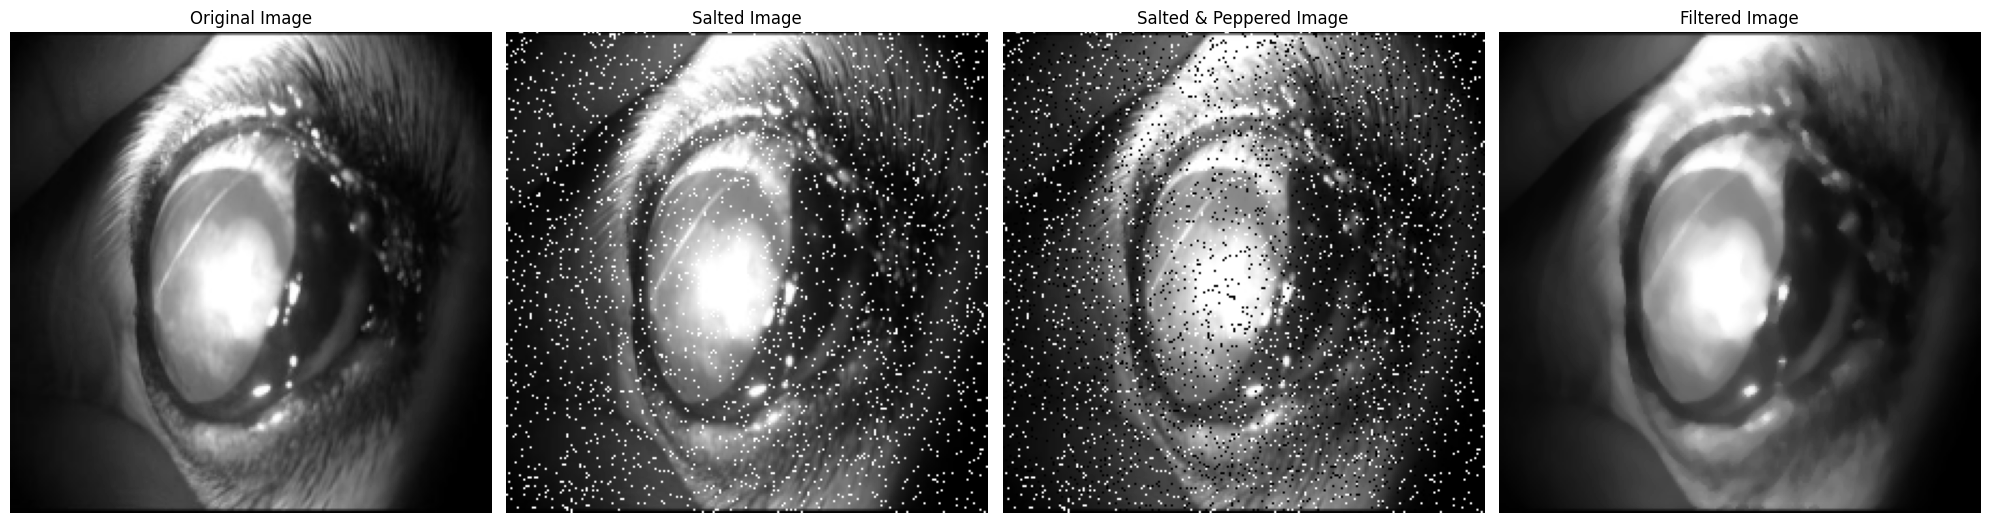

In [144]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 4, figsize=(20, 6))

axes[0].imshow(image, cmap='gray')
axes[0].axis('off')
axes[0].set_title('Original Image')

axes[1].imshow(salted_image, cmap='gray')
axes[1].axis('off')
axes[1].set_title('Salted Image')

axes[2].imshow(peppered_image, cmap='gray')
axes[2].axis('off')
axes[2].set_title('Salted & Peppered Image')

axes[3].imshow(filtered_image, cmap='gray')
axes[3].axis('off')
axes[3].set_title('Filtered Image')

plt.tight_layout()
plt.show()

In [145]:
normalize_image = filtered_image / 255
normalize_image


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00392157, ..., 0.        , 0.        ,
        0.        ],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00392157, 0.00392157, 0.00392157, ..., 0.        , 0.        ,
        0.        ],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00392157, ..., 0.        , 0.        ,
        0.        ]])

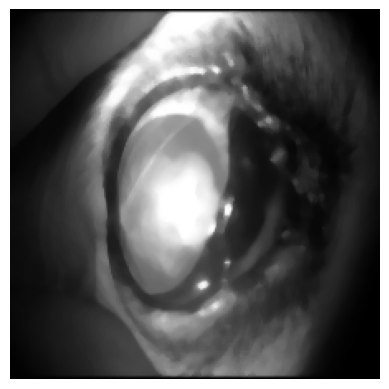

In [146]:
plt.imshow(normalize_image, cmap='gray')
plt.axis('off')
plt.show()

In [147]:
mean = tf.reduce_mean(normalize_image)
stddev = tf.math.reduce_std(normalize_image)

standardization_image = (normalize_image - mean) / stddev
standardization_image

<tf.Tensor: shape=(224, 224), dtype=float64, numpy=
array([[-1.09824853, -1.09824853, -1.09824853, ..., -1.09824853,
        -1.09824853, -1.09824853],
       [-1.09824853, -1.09824853, -1.08335295, ..., -1.09824853,
        -1.09824853, -1.09824853],
       [-1.08335295, -1.08335295, -1.08335295, ..., -1.09824853,
        -1.09824853, -1.09824853],
       ...,
       [-1.08335295, -1.08335295, -1.08335295, ..., -1.09824853,
        -1.09824853, -1.09824853],
       [-1.08335295, -1.08335295, -1.08335295, ..., -1.09824853,
        -1.09824853, -1.09824853],
       [-1.09824853, -1.09824853, -1.08335295, ..., -1.09824853,
        -1.09824853, -1.09824853]])>

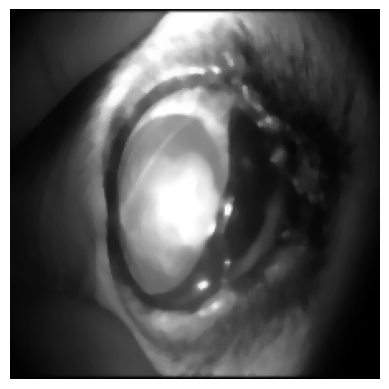

In [148]:
plt.imshow(standardization_image, cmap='gray')
plt.axis('off')
plt.show()

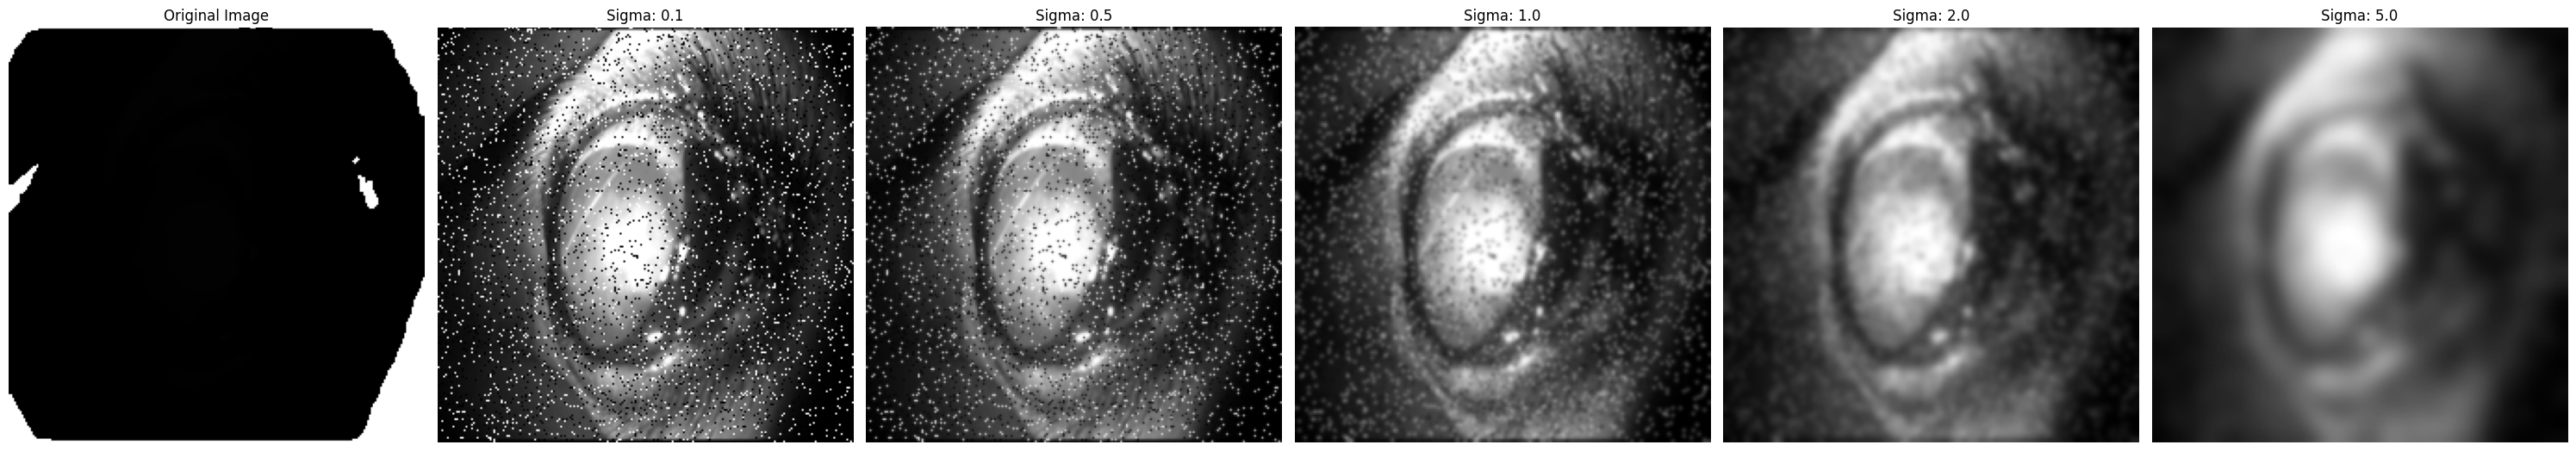

In [149]:
#image = cv2.imread('crop_D0_0d4f0dab-60a5-11ec-8402-0a7404972c70.png', cv2.IMREAD_GRAYSCALE)
image = np.array(standardization_image).astype('uint8')
gaussian_noise = np.random.normal(0, 0.1, image.shape).astype('uint8')
noisy_image = cv2.add(image, gaussian_noise)
sigma_values = [0.1, 0.5, 1.0, 2.0, 5.0]
denoised_images = []

for sigma in sigma_values:
    denoised_image = cv2.GaussianBlur(peppered_image_np, (0, 0), sigma)
    denoised_images.append(denoised_image)
    
fig, axes = plt.subplots(1, 6, figsize=(30, 6))
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

for ax, img, sigma in zip(axes[1:], denoised_images, sigma_values):
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Sigma: {sigma}')
    ax.axis('off')

plt.tight_layout()
plt.show()

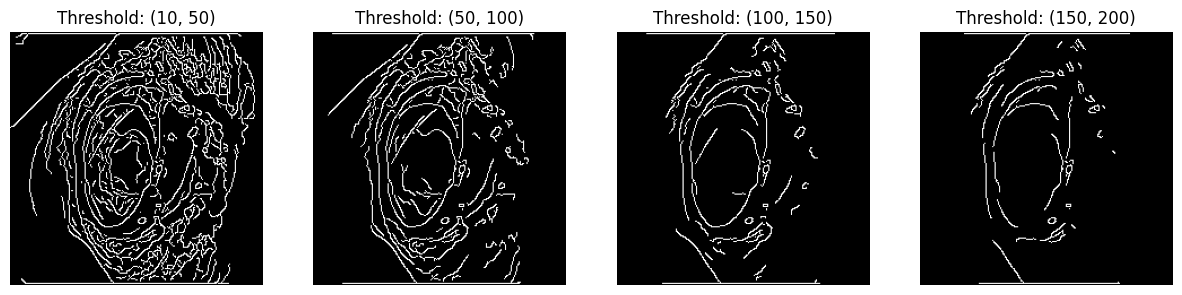

In [150]:
threshold = [(10, 50), (50, 100), (100, 150), (150, 200)]

canny_result = []

for th1, th2 in threshold:
    canny_edge = cv2.Canny(filtered_image, th1, th2)
    canny_result.append(canny_edge)
    
fig, ax = plt.subplots(1, 4, figsize=(15, 5))

for i in range(4):
    ax[i].imshow(canny_result[i], cmap='gray')
    ax[i].set_title(f'Threshold: {threshold[i]}')
    ax[i].axis('off')